In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
num_x_features = 3
num_y_features = 1
num_samples = 1
reg_p = 0.5

In [4]:
from scipy.special import expit as sigmoid

def lambdoid(xi):
    from scipy.special import exprel
    xi = -abs(xi)
    return 0.25*exprel(xi)/(np.exp(xi)+1)

def batch_inverse(A,*frozen_indices):
    assert len(A.shape)==len(frozen_indices)+2, "We need A to have exactly two more dimensions"\
           "than the number of indices frozen."
    from itertools import product
    lengths = [A.shape[i] for i in frozen_indices]
    index_reverse_lookup = {i:j for j,i in enumerate(frozen_indices)}
    A_inv = np.zeros(A.shape)
    for index in product(*map(range,lengths)):
        index = list(index)
        index_full = [index[index_reverse_lookup[i]] if i in frozen_indices else slice(None) 
                                for i in range(len(A.shape))]
        A_inv[index_full]  = np.linalg.inv(A[index_full])
    return A_inv

In [5]:
def KLDivergence(m1,Sig1,m2,Sig2):
    """Computes the KL divergence of two multivariate normal distributions. 
    mi and Sigi are the respective means and covariance matrices"""
    d = len(m1)
    Sig2inv = np.linalg.inv(Sig2)
    Sig2invSig1 = Sig2inv.dot(Sig1)
    return 0.5*(-np.linalg.slogdet(Sig2invSig1)[1]-d+np.trace(Sig2invSig1)+(m2-m1).T.dot(Sig2inv.dot(m2-m1)))

In [6]:
   
def update_params(X,H,W,S_W,W_0,reg_p):
    """
    Here X are the target labels, H is the input vector, and W are the weights
    This computes a full covariance matrix for W
    """
    S_W_0_inv = reg_p*np.tile(np.eye(W.shape[0])[:,np.newaxis,:],[1,W.shape[1],1])
    S_W_WW = S_W+np.einsum('ij,kj->ijk',W,W)
    Xi = np.sqrt(np.einsum('ij,jlk,ik->il',H,S_W_WW,H))
    
    
    LXi = sum(lower_log_marginal_likelihood_bound(W[:,i], S_W[:,i,:], Xi, W_0[:,i], reg_p)
             for i in range(W.shape[1]))
    #LXi = lower_log_probability(X,H,W,S_W,Xi)
    
    S_W_inv_ = S_W_0_inv + 2* np.einsum('il,ij,ik->jlk', lambdoid(Xi),H,H)
    S_W_ = batch_inverse(S_W_inv_,1)
    W_ = np.einsum('ljk,ij,ik->lj',S_W_,(X-0.5),H)
    
    LW = sum(lower_log_marginal_likelihood_bound(W_[:,i], S_W_[:,i,:], Xi, W_0[:,i], reg_p)
             for i in range(W.shape[1]))
    #LW = lower_log_probability(X,H,W_,S_W_,Xi)
    
    return (W_,S_W_), (LXi,LW)


def update_params_diag(X,H,W,S_W,W_0,reg_p):
    """
    Here X are the target labels, H is the input vector, and W are the weights
    This computes diagonal variances for W.
    """
    S_W_0_inv = reg_p*np.ones(W.shape)
    S_W_WW = S_W+np.einsum('ij,ij->ij',W,W)
    Xi = np.sqrt(np.einsum('ij,jl,ij->il',H,S_W_WW,H))
    S_W_inv_ = S_W_0_inv + 2*np.einsum('il,ij,ij->jl', lambdoid(Xi),H,H)
    S_W_ = np.reciprocal(S_W_inv_)
    
    midterm = X-0.5-2*lambdoid(Xi)*(H.dot(W))
    
    W_ = np.einsum('lj,ij,il->lj',S_W_,midterm,H)+2*np.einsum('ij,ij->ij',S_W_,W*(H**2).T.dot(lambdoid(Xi)))
    
    return (W_,S_W_)


def update_params_diag_2(X,H,W,S_W,W_0,reg_p):
    """
    Here X are the target labels, H is the input vector, and W are the weights
    This computes diagonal variances for W.
    This is the same formula as update_params_diag, but with slightly different code
    """
    S_W_0_inv = reg_p*np.ones(W.shape)
    S_W_WW = S_W+np.einsum('ij,ij->ij',W,W)
    Xi = np.sqrt(np.einsum('ij,jl,ij->il',H,S_W_WW,H))
    S_W_inv_ = S_W_0_inv + 2*np.einsum('il,ij,ij->jl', lambdoid(Xi),H,H)
    S_W_ = np.reciprocal(S_W_inv_)
    
    midterm = H.T.dot(X-0.5-2*lambdoid(Xi)*(H.dot(W)))+2*W*(H**2).T.dot(lambdoid(Xi))
    
    W_ = np.einsum('ij,ij->ij',S_W_,midterm)
    
    return (W_,S_W_)



def update_weights(T,W,X,Xi,W_0,reg):
    """Update the weight matrix
    T = observed values
    W = weights (at current iteration of VB)
    X = features
    Xi = JJ positions (at current iteration of VB)
    W_0 = prior bias for W
    reg = regularization strength
    
    we assume T ~ Bernouilli(sigmoid(XW))
    returns (W,Sig_W)
    where W are the updated weight values and Sig_W are the current variances of those weight values.
    """
    k = (len(X.shape)+len(W.shape)-len(T.shape))//2 # number of indices to contract over.
    S_W_0_inv = reg*np.ones(W.shape)
    
    lamXi = lambdoid(Xi)
    
    X2lamXi = np.tensordot((X**2).T,lamXi,k)
    
    S_W_inv_ = S_W_0_inv + 2*X2lamXi
    S_W_ = np.reciprocal(S_W_inv_)
    
    term1 = np.tensordot(X.T, T-0.5-2*lamXi*np.tensordot(X,W,k),k)
    term2 = 2*W*X2lamXi
    
    W_ = S_W_*(S_W_0_inv*W_0+term1+term2)
    
    return W_, S_W_
    
    
def update_params_diag_3(X,H,W,S_W,W_0,reg_p):
    """
    Here X are the target labels, H is the input vector, and W are the weights
    This computes diagonal variances for W.
    This is the same formula as update_params_diag, but with slightly different code
    """
    S_W_WW = S_W+np.einsum('ij,ij->ij',W,W)
    Xi = np.sqrt(np.einsum('ij,jl,ij->il',H,S_W_WW,H))
    #LW = lower_log_marginal_likelihood_bound_diag_alt(X,H, W, S_W, Xi, reg_p)
    #LXi = lower_log_marginal_likelihood_bound_diag_alt(X,H, W, S_W, Xi, reg_p)
    LXi = lower_log_marginal_likelihood_bound_diag_var(W, S_W, Xi, W_0, reg_p)
    #LXi = lower_log_probability(X,H,W,S_W,Xi)
    
    
    (W_,S_W_) = update_weights(X,W,H,Xi,W_0,reg_p)
    #LW = lower_log_marginal_likelihood_bound_diag_alt(X,H, W_, S_W_, Xi, reg_p)
    LW = lower_log_marginal_likelihood_bound_diag_var(W_, S_W_, Xi, W_0, reg_p)
    #LW = lower_log_probability(X,H,W_,S_W_,Xi)
    
    return (W_,S_W_), (LXi,LW)

In [7]:
def lower_log_marginal_likelihood_bound_diag_var(W, S_W, Xi, W_0, reg_p):
    term1 = 0.5*np.log((S_W*reg_p)).sum()
    term2 = 0.5*((W**2)*np.reciprocal(S_W)-(W_0**2)*reg_p).sum()
    term3 = (np.log(sigmoid(Xi))-0.5*Xi+lambdoid(Xi)*(Xi**2)).sum()
    return term1+term2+term3

def lower_log_marginal_likelihood_bound(W, S_W, Xi, W_0, reg_p):
    term1 = 0.5*np.linalg.slogdet(S_W*reg_p)[1]
    term2 = 0.5*W.dot(np.linalg.inv(S_W).dot(W))-0.5*((W_0**2)*reg_p).sum()
    term3 = (np.log(sigmoid(Xi))-0.5*Xi+lambdoid(Xi)*(Xi**2)).sum()
    return term1+term2+term3

In [8]:
def log_1_add_exp(x):
    mask = x<0
    nmask = np.logical_not(mask)
    ans = np.zeros_like(x)
    ans[mask] = np.log1p(np.exp(x[mask]))
    ans[nmask] = np.log1p(np.exp(-x[nmask]))+x[nmask]
    return ans


def KLDivergence_diag(m1,Sig1,m2,Sig2):
    """Computes the KL divergence of two multivariate normal distributions. 
    mi and Sigi are the respective means and covariance matrices"""
    d = len(m1.flatten())
    Sig2inv = np.reciprocal(Sig2)
    Sig2invSig1 = Sig2inv*Sig1
    return 0.5*(-np.log(Sig2invSig1).sum()-d+Sig2invSig1.sum()+(((m2-m1)**2)*Sig2inv).sum())

def lower_log_marginal_likelihood_bound_diag_alt(X,H,W,Sig_W,Xi,reg_p):
    KLW = KLDivergence_diag(W,Sig_W,np.zeros_like(W),np.ones_like(W)/reg_p)
    HW = H.dot(W)
    HW2 = (H**2).dot(Sig_W)+HW**2
    lamXi = lambdoid(Xi)
    lseW = (lamXi*(HW2-Xi**2)+0.5*(HW-Xi)+log_1_add_exp(Xi)).sum()
    e_log_likelihood = (X*HW).sum()-lseW
    #e_log_likelihood = (np.log(sigmoid(Xi))+0.5*(HW-Xi)-lambdoid(Xi)*(HW2-Xi**2)).sum()
    return KLW-e_log_likelihood

def lower_log_probability(X,H,W,Sig_W,Xi):
    """Jaakola and Jordan use this in Ap.C of Bayesian parameter estimation via
    variational methods"""
    HW = H.dot(W)
    JH = 2*(X-1)*(HW)
    lamXi = lambdoid(Xi)
    e_log_likelihood = (np.log(sigmoid(Xi))+0.5*(JH-Xi)-lamXi*(JH**2-Xi**2)).sum()
    return e_log_likelihood

In [9]:
_W = np.random.randn(num_x_features, num_y_features)

In [10]:
def bernoulli(p):
    rands = np.random.rand(*np.array(p).shape)
    return np.array(rands < p,dtype=np.float)

In [11]:
def generate_cases(num_x_features, num_y_features, avg_ddx_length, w, num_samples=10):
    h = np.random.randn(num_samples,num_x_features)
    h[:,2]=1
    y = h# bernoulli(sigmoid(diff_op(h)))
    x = bernoulli(sigmoid(h.dot(w)))
    #x = sigmoid(h.dot(w))
    return x,y,h

In [12]:
X,Y,H_0 = generate_cases(num_x_features=num_x_features, num_y_features=num_y_features, w=_W, avg_ddx_length=1, num_samples=num_samples)

In [13]:
alpha = 0.003
W_diag_list = []
def fit(X, Y, num_x_features, reg_p):
    L_list = []
    L_diag_list = []
    num_samples, num_y_features = X.shape
    H = H_0
    W_full = np.zeros([num_x_features,num_y_features]) 
    #np.random.randn(num_x_features, num_y_features)/np.sqrt(float(num_x_features+num_y_features))
    W_diag = np.zeros([num_x_features,num_y_features])
    W_0 = np.zeros([num_x_features,num_y_features])
    Sig_W = np.tile(np.eye(num_x_features)[:,np.newaxis,:],[1,num_y_features,1])
    Sig_W_diag = np.ones([num_x_features,num_y_features])
    for i in range(30):
        (W_full,Sig_W), L = update_params(X,H,W_full,Sig_W,W_0,reg_p)
        L_list+=list(L)
        (W_diag,Sig_W_diag), L = update_params_diag_3(X,H,W_diag,Sig_W_diag,W_0,reg_p)
        L_diag_list+=list(L)
        #(W_diag,Sig_W_diag) = update_params_diag(X,H,W_diag,Sig_W_diag,W_0,reg_p)
        W_diag_list.append(W_diag)
    return (W_full,Sig_W), (W_diag,Sig_W_diag), L_list, L_diag_list

In [14]:
%%timeit
(W_full,Sig_W), (W_diag,Sig_W_diag), L_list, L_diag_list = fit(X, Y, num_x_features,reg_p)

14.3 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
m1 = W_diag[:,0]
Sig1 = Sig_W_diag[:,0]*np.eye(len(m1))
m2 = W_full[:,0]
Sig2 = Sig_W[:,0,:]
KL = KLDivergence(m1,Sig1,m2,Sig2)
KL

NameError: name 'W_diag' is not defined

In [16]:
skip = 1
offset = 0
#plt.plot(range(len(L_diag_list)),np.array(L_diag_list)[:,0]-np.array(L_diag_list)[:,1],color='red')
#plt.plot(range(len(L_diag_list)),np.array(L_diag_list)[:,0],color='red')
#plt.plot(range(len(L_diag_list)),np.array(L_diag_list)[:,1],'purple')
#plt.plot(range(len(L_list)),np.array(L_list)[:,0],color='green')
#plt.plot(range(len(L_list)),np.array(L_list)[:,1],color='blue')
plt.plot(range(len(L_list)//skip),[x for i,x in enumerate(L_list) if i % skip ==offset],color='red')
plt.show()
plt.plot(range(len(L_diag_list)//skip),[x for i,x in enumerate(L_diag_list) if i % skip ==offset],color='blue')
#plt.plot(range(len(L_list)),[L+KL for L in L_list],color='purple')

NameError: name 'L_list' is not defined

In [ ]:
data = H_0.dot(_W).flatten()
pred_d = H_0.dot(W_diag).flatten()
pred_f = H_0.dot(W_full).flatten()
#dev = H.dot((W+np.sqrt(Sig_W))).flatten()#+(H+np.sqrt(Sig_H)).dot(W).flatten()
#plt.scatter(data,dev)
plt.scatter(data,pred_d,color='blue')
plt.scatter(data,pred_f,color='red')
#plt.scatter(range(len(data)),pred)

In [ ]:
x_data_pts = np.array([(x/z,y/z) for x,y,z in H_0])

In [ ]:
W_samples_diag = np.random.multivariate_normal(W_diag[:,0],np.eye(W_diag[:,0].shape[0])*Sig_W_diag[:,0],size=50)
W_samples = np.random.multivariate_normal(W_full[:,0],Sig_W[:,0],size=50)
# W_samples_diag = W_diag[np.newaxis,:,0]
# W_samples = W_full[np.newaxis,:,0]

In [ ]:
plt.scatter(x_data_pts[:,0][X.flatten()>0.5],x_data_pts[:,1][X.flatten()>0.5],color='red')
plt.scatter(x_data_pts[:,0][X.flatten()<=0.5],x_data_pts[:,1][X.flatten()<=0.5],color='blue')

x_axis = np.linspace(-5,5,50)
y_axis = np.linspace(-5,5,50)
x_grid, y_grid = np.meshgrid(x_axis, y_axis)
grid = np.stack([x_grid,y_grid,np.ones_like(x_grid)])
z_grid = np.einsum('i,ijk->jk',_W[:,0],grid)
levels=[0]
plt.contour(x_grid,y_grid,z_grid,levels,colors='k')

zz_grid = sigmoid(np.einsum('li,ijk->ljk',W_samples,grid)).mean(axis=0)-0.5
CS = plt.contour(x_grid,y_grid,-zz_grid,cmap='RdBu')
plt.contour(x_grid,y_grid,-zz_grid,levels)
plt.clabel(CS, inline=1, fontsize=10)

In [ ]:
plt.scatter(x_data_pts[:,0][X.flatten()>0.5],x_data_pts[:,1][X.flatten()>0.5],color='red')
plt.scatter(x_data_pts[:,0][X.flatten()<=0.5],x_data_pts[:,1][X.flatten()<=0.5],color='blue')

x_axis = np.linspace(-5,5,50)
y_axis = np.linspace(-5,5,50)
x_grid, y_grid = np.meshgrid(x_axis, y_axis)
grid = np.stack([x_grid,y_grid,np.ones_like(x_grid)])
z_grid = np.einsum('i,ijk->jk',_W[:,0],grid)
levels=[0]
plt.contour(x_grid,y_grid,z_grid,levels,colors='k')

zz_diag_grid = sigmoid(np.einsum('li,ijk->ljk',W_samples_diag,grid)).mean(axis=0)-0.5
CS = plt.contour(x_grid,y_grid,-zz_diag_grid,cmap='RdBu')
plt.contour(x_grid,y_grid,-zz_diag_grid,levels)
plt.clabel(CS, inline=1, fontsize=10)

In [ ]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1./reg_p)
logreg.fit(H_0[:,:2],X.flatten())

plt.scatter(x_data_pts[:,0][X.flatten()>0.5],x_data_pts[:,1][X.flatten()>0.5],color='red')
plt.scatter(x_data_pts[:,0][X.flatten()<=0.5],x_data_pts[:,1][X.flatten()<=0.5],color='blue')

x_axis = np.linspace(-5,5,50)
y_axis = np.linspace(-5,5,50)
x_grid, y_grid = np.meshgrid(x_axis, y_axis)
grid = np.stack([x_grid,y_grid,np.ones_like(x_grid)])
z_grid = np.einsum('i,ijk->jk',W_full[:,0],grid)
levels=[0.]
plt.contour(x_grid,y_grid,z_grid,levels,colors='red')
z_grid = np.einsum('i,ijk->jk',W_diag[:,0],grid)
levels=[0.]
plt.contour(x_grid,y_grid,z_grid,levels,colors='blue')


Z = logreg.predict_proba(np.c_[x_grid.ravel(), y_grid.ravel()])
Z = Z[:,0].reshape(x_grid.shape)

plt.contour(x_grid,y_grid,Z,[0.5],colors='k')

In [ ]:
plt.plot(range(len(W_diag_list)),[abs(x[0,0]-W_diag[0,0]) for x in W_diag_list])

In [ ]:
x_axis = np.linspace(-5,5,50)
y_axis = np.linspace(-5,5,50)
x_grid, y_grid = np.meshgrid(x_axis, y_axis)
grid = np.stack([x_grid,y_grid,np.ones_like(x_grid)])

grid_full = grid-W_full[0,:,np.newaxis,np.newaxis]
z_grid = np.einsum('ijk,il,ljk->jk',grid_full,np.linalg.inv(Sig_W[:,0,:]),grid_full)
plt.contour(x_grid,y_grid,z_grid,colors='red')

# z_grid = np.einsum('i,ijk->jk',W_full[:,0],grid)
# levels=[0.]
# plt.contour(x_grid,y_grid,z_grid,levels,colors='red')
x,y,z = W_full[:,0]
plt.scatter(x/z,y/z,color='red')

grid_diag = grid-W_diag[0,:,np.newaxis,np.newaxis]
z_grid = np.einsum('ijk,i,ijk->jk',grid,np.reciprocal(Sig_W_diag[0,:]),grid)
plt.contour(x_grid,y_grid,z_grid,colors='blue')

# z_grid = np.einsum('i,ijk->jk',W_diag[:,0],grid)
# levels=[0.]
# plt.contour(x_grid,y_grid,z_grid,levels,colors='blue')
x,y,z = W_diag[:,0]
plt.scatter(x/z,y/z,color='blue')

In [ ]:
W_diag

In [ ]:
W_full

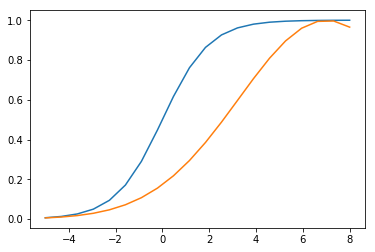

In [18]:
x = np.linspace(-5,8,20)
y = sigmoid(x)
xi = -7.
z = sigmoid(xi)*np.exp((x-xi)/2-lambdoid(xi)*(x**2-xi**2))
plt.plot(x,y)
plt.plot(x,z)

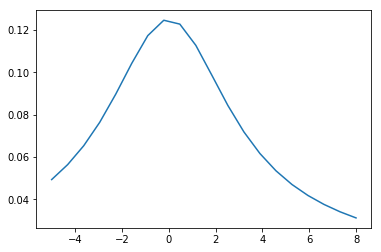

In [20]:
plt.plot(x,lambdoid(x))